# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import jsonlines
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "src")
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "../")
from synthetic_performance_eval_script import *
from performance_evaluation import CustomPerformanceEvaluator
from benchmarking.utils import read_perf_eval_json_files

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

Benchmarking Endpoint: ad64853e-c96d-45c8-b98f-72a6a650e73b


#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen-2.5-72B-SD-Qwen-2.5-0.5B',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen2.5-72B-Instruct',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [12]:
run_name = "llama33_70b_xlam2_70b_customdata_20250603_1"

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [13]:
target_models = ['Meta-Llama-3.3-70B-Instruct',
 'Salesforce--Llama-xLAM-2-70b-fc-r']

#### Read custom input file
Note that the file needs to be in jsonl format as shown in the example below. For image prompts, each line should contain a `prompt` key and an `image_path` key. The value of `image_path` should be the image encoded as text.

In [19]:
custom_input_path = f"{benchmarking_dir}/prompts/custom_prompt_example.jsonl"    
prompts = []
with open(custom_input_path, "r") as f:
    for line in f:
        prompts.append(line.strip())
prompts = list(set(prompts))[:5]
prompts

['{"prompt": "Explain the theory of relativity in detail."}',
 '{"prompt": "Given the following text, extract and summarize the key points in a structured format: \'In the past decade, renewable energy has grown significantly due to advancements in technology and governmental incentives. Solar and wind power have become cost-effective alternatives to fossil fuels. However, challenges such as energy storage and infrastructure adaptation remain. Many countries are implementing policies to accelerate the transition toward cleaner energy sources.\'"}',
 '{"prompt": "Here is a list of 20 numbers: 5, 12, 8, 20, 3, 15, 9, 30, 2, 18, 7, 25, 11, 14, 6, 22, 19, 1, 10, 4. Find the median value."}',
 '{"prompt": "Analyze the impact of artificial intelligence on modern society, considering ethical, economic, and technological aspects. Provide a well-reasoned argument with examples."}',
 '{"prompt": "Define \'entropy\' in one sentence."}']

#### Specify configs for benchmarking

In [15]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"

config = {
    'sampling_params': {'max_tokens_to_generate': 1000},    
    'output_files_dir': os.path.join(f'{output_path}logs/output_files/', run_name), # each run saved here
    'consolidated_results_dir': os.path.join(f'{output_path}consolidated_results', run_name), # consolidated xlsx saved here
    'timeout': 3600,
    'num_requests': 64,
    'concurrent_requests': [4, 8, 16],
    'save_response_texts': False,
    'llm_api': 'sambastudio'
}

## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Benchmarking produces json files with detailed results for each configuration

In [ ]:
for target_model in target_models:
    for num_concurrent_requests in config['concurrent_requests']:        
        for i, prompt in enumerate(prompts):
            # Create file with output
            os.makedirs(config['output_files_dir'], exist_ok=True)
            prompt_file_path = os.path.join(config['output_files_dir'], f"custom_prompt_{i}.jsonl")
            
            with jsonlines.open(prompt_file_path, "w") as writer:
                for j in range(config['num_requests']):
                    writer.write(json.loads(prompt))

            custom_evaluator = CustomPerformanceEvaluator(
                model_name=target_model,        
                results_dir=config['output_files_dir'],
                num_concurrent_requests=num_concurrent_requests,
                timeout=config["timeout"],
                user_metadata={"model_idx": 0},
                input_file_path=prompt_file_path,
                save_response_texts=config['save_response_texts'],
                llm_api=config['llm_api'],
            )
            # Run performance evaluation
            custom_evaluator.run_benchmark(sampling_params=config['sampling_params'])

#### Consolidate all results into pandas dataframe

In [21]:
output_files_dir = config['output_files_dir']
df_summary = read_perf_eval_json_files(output_files_dir, type='summary')
missing_columns = []

if 'num_concurrent_requests' not in df_summary.columns:
    missing_columns.append('num_concurrent_requests')

if 'multimodal_img_size' not in df_summary.columns or df_summary['multimodal_img_size'].isnull().all():
    missing_columns.append('multimodal_img_size')

# Set fields to report
selected_columns = [
    'name',
    'model',    
    'number_input_tokens_min',
    'number_input_tokens_max',
    'number_output_tokens_min',
    'number_output_tokens_max',
    'num_concurrent_requests',
    'multimodal_img_size',
    'server_ttft_s_min',
    'server_ttft_s_p50',
    'server_ttft_s_max',
    'server_end_to_end_latency_s_min',
    'server_end_to_end_latency_s_p50',
    'server_end_to_end_latency_s_max',
    'server_output_token_per_s_min',
    'server_output_token_per_s_p50',
    'server_output_token_per_s_max',
    'server_output_token_per_s_mean',                
    'acceptance_rate_min',
    'acceptance_rate_p50',
    'acceptance_rate_max',
    'server_number_input_tokens_p50',
    'server_number_output_tokens_p50',
    'client_ttft_s_min',
    'client_ttft_s_p50',
    'client_ttft_s_max',
    'client_end_to_end_latency_s_min',
    'client_end_to_end_latency_s_p50',
    'client_end_to_end_latency_s_max',
    'client_output_token_per_s_min',
    'client_output_token_per_s_p50',
    'client_output_token_per_s_max',
    'client_output_token_per_s_mean',
    'client_mean_output_token_per_s',
    'num_requests_started',
    'num_completed_requests',
    'num_completed_requests_per_min',
    'number_errors',
    'error_code_frequency',
]

selected_columns = [c for c in selected_columns if c not in missing_columns]
# Set fields to report
df_summary = df_summary[selected_columns]
df_summary['model'] = df_summary['model'].str.replace('.', '-')
df_summary['requests_grouping'] = pd.Series(None, index=df_summary.index, dtype=object)
df_summary['requests_batching'] = pd.Series(None, index=df_summary.index, dtype=object)

# Add UUID to summary and set as index
#df_summary['uuid'] = df_summary.apply(lambda x: find_uuid(x['name']), axis=1)
df_summary = df_summary.set_index('name')

# Read individual responses
df = read_perf_eval_json_files(output_files_dir, type='individual_responses')

# Process individual files and add requests batching approximation
for filename in os.listdir(output_files_dir):
    if 'individual_responses' in filename:
        df_file = df[df['filename'] == filename].copy()
        df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)

        key = filename[:filename.index("_individual_responses.json")] + "_summary"
        total_input_tokens = df_file["number_input_tokens"].sum()
        total_output_tokens = df_file["number_output_tokens"].sum()

        if key in df_summary.index:
            df_summary.at[key, 'requests_grouping'] = requests_grouping
            df_summary.at[key, 'requests_batching'] = requests_batching
            df_summary.at[key, 'total_input_tokens'] = total_input_tokens
            df_summary.at[key, 'total_output_tokens'] = total_output_tokens
        else:
            raise KeyError(f'Key {key} not found in dictionary. File: {file}')
df_summary['representative_batch_size'] = df_summary['requests_batching'].apply(
    lambda x: find_median_in_batches(x)
)

# Sort and save the summary DataFrame
consolidated_results_dir = os.path.expanduser(config['consolidated_results_dir'])
if not os.path.exists(consolidated_results_dir):
    os.makedirs(consolidated_results_dir)

df_summary["number_input_tokens_min"] = df_summary["number_input_tokens_min"].astype(int)
df_summary["number_output_tokens_min"] = df_summary["number_output_tokens_min"].astype(int)

sort_columns = ['model', 'num_concurrent_requests', 'number_input_tokens_min', 'number_output_tokens_min']
if 'num_concurrent_requests' in df_summary.columns:
    sort_columns.append('num_concurrent_requests')
df_summary.sort_values(by=sort_columns, inplace=True)

df_summary["server_rated_throughput"] = df_summary["server_output_token_per_s_mean"] * df_summary["representative_batch_size"]
df_summary["total_latency"] =  df_summary["num_completed_requests"]*60/df_summary["num_completed_requests_per_min"]
df_summary["client_output_throughput"] = df_summary["total_output_tokens"]/df_summary["total_latency"]
df_summary["client_total_throughput"] = (df_summary["total_input_tokens"]+df_summary["total_output_tokens"])/df_summary["total_latency"]

df_summary.to_excel(os.path.join(consolidated_results_dir, f'{run_name}.xlsx'))


## 6. Compare with alternative benchmarking results

In [23]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [24]:
current_name = "V1 Performance"
alt_name = "V2 Performance"

#### Read results from current run

In [25]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,43,43,48,48,4,0.2798,0.2805,0.2821,0.6094,0.6111,0.6130,141.4853,142.2571,142.5982,142.2485,NaN,NaN,NaN,43,48,0.3976,1.0563,1.0924,0.7248,1.3849,1.4216,144.1818,146.1335,150.6549,146.1767,138.0697,64,64,172.5872,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2752,3072,2,284.4970,22.249622,138.069760,261.757253,V1 Performance
1,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,45,45,858,858,4,0.0979,0.2811,0.2829,5.6908,6.1301,6.1374,146.3327,146.5347,153.2353,148.1742,NaN,NaN,NaN,45,858,0.2652,6.1357,6.3932,5.8493,11.9801,12.2643,145.9801,146.7702,153.6505,148.3012,286.1720,64,64,20.0120,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",2880,54912,4,592.6968,191.884869,286.171600,301.180600,V1 Performance
2,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,65,65,738,738,4,0.0977,0.2814,0.2830,4.9083,5.3127,5.3166,146.3678,146.4893,153.2112,148.1339,NaN,NaN,NaN,65,738,0.2259,5.3507,5.5756,5.0370,10.3800,10.4334,146.5213,146.7218,153.5130,148.3475,284.0969,64,64,23.0973,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4160,47232,4,592.5356,166.253198,284.096790,309.118865,V1 Performance
3,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,109,109,168,168,4,0.2797,0.2811,0.2820,1.4272,1.4285,1.4307,145.2779,145.5391,145.6119,145.5238,NaN,NaN,NaN,109,168,0.4115,1.8743,1.9236,1.5605,3.0204,3.0688,146.1691,146.6305,146.9454,146.5929,221.9971,64,64,79.2847,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",6976,10752,2,291.0476,48.433052,221.997160,366.031032,V1 Performance
4,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,110,110,133,133,4,0.0974,0.2805,0.2815,0.9976,1.2225,1.2618,134.4568,140.1734,146.6631,141.4884,NaN,NaN,NaN,110,133,0.1950,1.4433,1.5295,1.0943,2.3828,2.4240,137.3817,141.4944,148.6934,142.8587,222.5752,64,64,100.4099,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",7040,8512,4,565.9536,38.243241,222.575278,406.660095,V1 Performance


#### Read results from alternative source

In [26]:
alt_run_name = "llama33_70b_customdata_20250603_1"
alt_file_path = os.path.join(f'{output_path}consolidated_results', alt_run_name, f'{alt_run_name}.xlsx')
df_alt = pd.read_excel(alt_file_path, sheet_name='Sheet1')
df_alt["provider"] = alt_name
df_alt.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,43,43,48,48,4,0.0696,0.1238,0.1321,0.2819,0.3652,0.3766,187.5839,192.0966,220.0759,198.1305,NaN,NaN,NaN,43,48,0.1722,0.4315,0.5311,0.3810,0.6690,0.7713,194.5098,200.7159,230.4366,206.7301,282.4089,64,64,353.0111,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",2752,3072,4,792.5220,10.877845,282.408880,535.400168,V2 Performance
1,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,45,45,835,835,4,0.0906,0.0939,0.1057,1.9724,1.9975,2.0237,431.6342,436.3040,441.5753,436.2826,NaN,NaN,NaN,45,835,0.2960,2.1153,2.3075,2.2023,4.0225,4.2168,433.1816,438.0441,453.9305,438.1113,826.6846,64,64,59.4025,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2880,53440,2,872.5652,64.643744,826.684792,871.236667,V2 Performance
2,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,65,65,740,740,4,0.0692,0.1244,0.1303,1.9978,2.3273,2.3701,327.0492,334.2107,381.8183,344.4709,NaN,NaN,NaN,65,740,0.1986,2.1655,2.4834,2.1706,4.3630,4.5481,328.1545,334.9231,383.1259,345.5696,673.7062,64,64,54.6248,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4160,47360,4,1377.8836,70.297740,673.705867,732.882733,V2 Performance
3,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,109,109,168,168,4,0.0696,0.1229,0.1282,0.4345,0.5406,0.5518,394.2084,397.0513,453.7920,409.6769,NaN,NaN,NaN,109,168,0.2035,0.5915,0.7181,0.5759,1.0050,1.1362,400.2459,404.4215,464.0395,417.3006,660.9909,64,64,236.0682,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",6976,10752,4,1638.7076,16.266486,660.990960,1089.848190,V2 Performance
4,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,110,110,132,132,4,0.0697,0.1232,0.1353,0.3935,0.4928,0.5121,344.9928,350.6035,401.0606,360.5459,NaN,NaN,NaN,110,132,0.2128,0.5533,0.7021,0.5504,0.9175,1.0750,351.1517,357.4963,409.6666,368.3601,566.1741,64,64,257.3519,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",7040,8448,4,1442.1836,14.921203,566.174180,1037.985997,V2 Performance


#### Combine dataframes

In [27]:
df_current.shape, df_alt.shape

((30, 48), (15, 48))

In [28]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

48

In [30]:
first_columns = ['provider','model','num_concurrent_requests', 'total_input_tokens','total_output_tokens', 'total_latency', 'server_rated_throughput', 'client_output_throughput', 'client_total_throughput']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

,provider,model,num_concurrent_requests,total_input_tokens,total_output_tokens,total_latency,server_rated_throughput,client_output_throughput,client_total_throughput,name,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,2752,3072,22.249622,284.4970,138.069760,261.757253,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,43,43,48,48,0.2798,0.2805,0.2821,0.6094,0.6111,0.6130,141.4853,142.2571,142.5982,142.2485,NaN,NaN,NaN,43,48,0.3976,1.0563,1.0924,0.7248,1.3849,1.4216,144.1818,146.1335,150.6549,146.1767,138.0697,64,64,172.5872,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2
1,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,2880,54912,191.884869,592.6968,286.171600,301.180600,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,45,45,858,858,0.0979,0.2811,0.2829,5.6908,6.1301,6.1374,146.3327,146.5347,153.2353,148.1742,NaN,NaN,NaN,45,858,0.2652,6.1357,6.3932,5.8493,11.9801,12.2643,145.9801,146.7702,153.6505,148.3012,286.1720,64,64,20.0120,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4
2,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,4160,47232,166.253198,592.5356,284.096790,309.118865,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,65,65,738,738,0.0977,0.2814,0.2830,4.9083,5.3127,5.3166,146.3678,146.4893,153.2112,148.1339,NaN,NaN,NaN,65,738,0.2259,5.3507,5.5756,5.0370,10.3800,10.4334,146.5213,146.7218,153.5130,148.3475,284.0969,64,64,23.0973,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4
3,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,6976,10752,48.433052,291.0476,221.997160,366.031032,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,109,109,168,168,0.2797,0.2811,0.2820,1.4272,1.4285,1.4307,145.2779,145.5391,145.6119,145.5238,NaN,NaN,NaN,109,168,0.4115,1.8743,1.9236,1.5605,3.0204,3.0688,146.1691,146.6305,146.9454,146.5929,221.9971,64,64,79.2847,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2
4,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,7040,8512,38.243241,565.9536,222.575278,406.660095,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,110,110,133,133,0.0974,0.2805,0.2815,0.9976,1.2225,1.2618,134.4568,140.1734,146.6631,141.4884,NaN,NaN,NaN,110,133,0.1950,1.4433,1.5295,1.0943,2.3828,2.4240,137.3817,141.4944,148.6934,142.8587,222.5752,64,64,100.4099,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4


### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

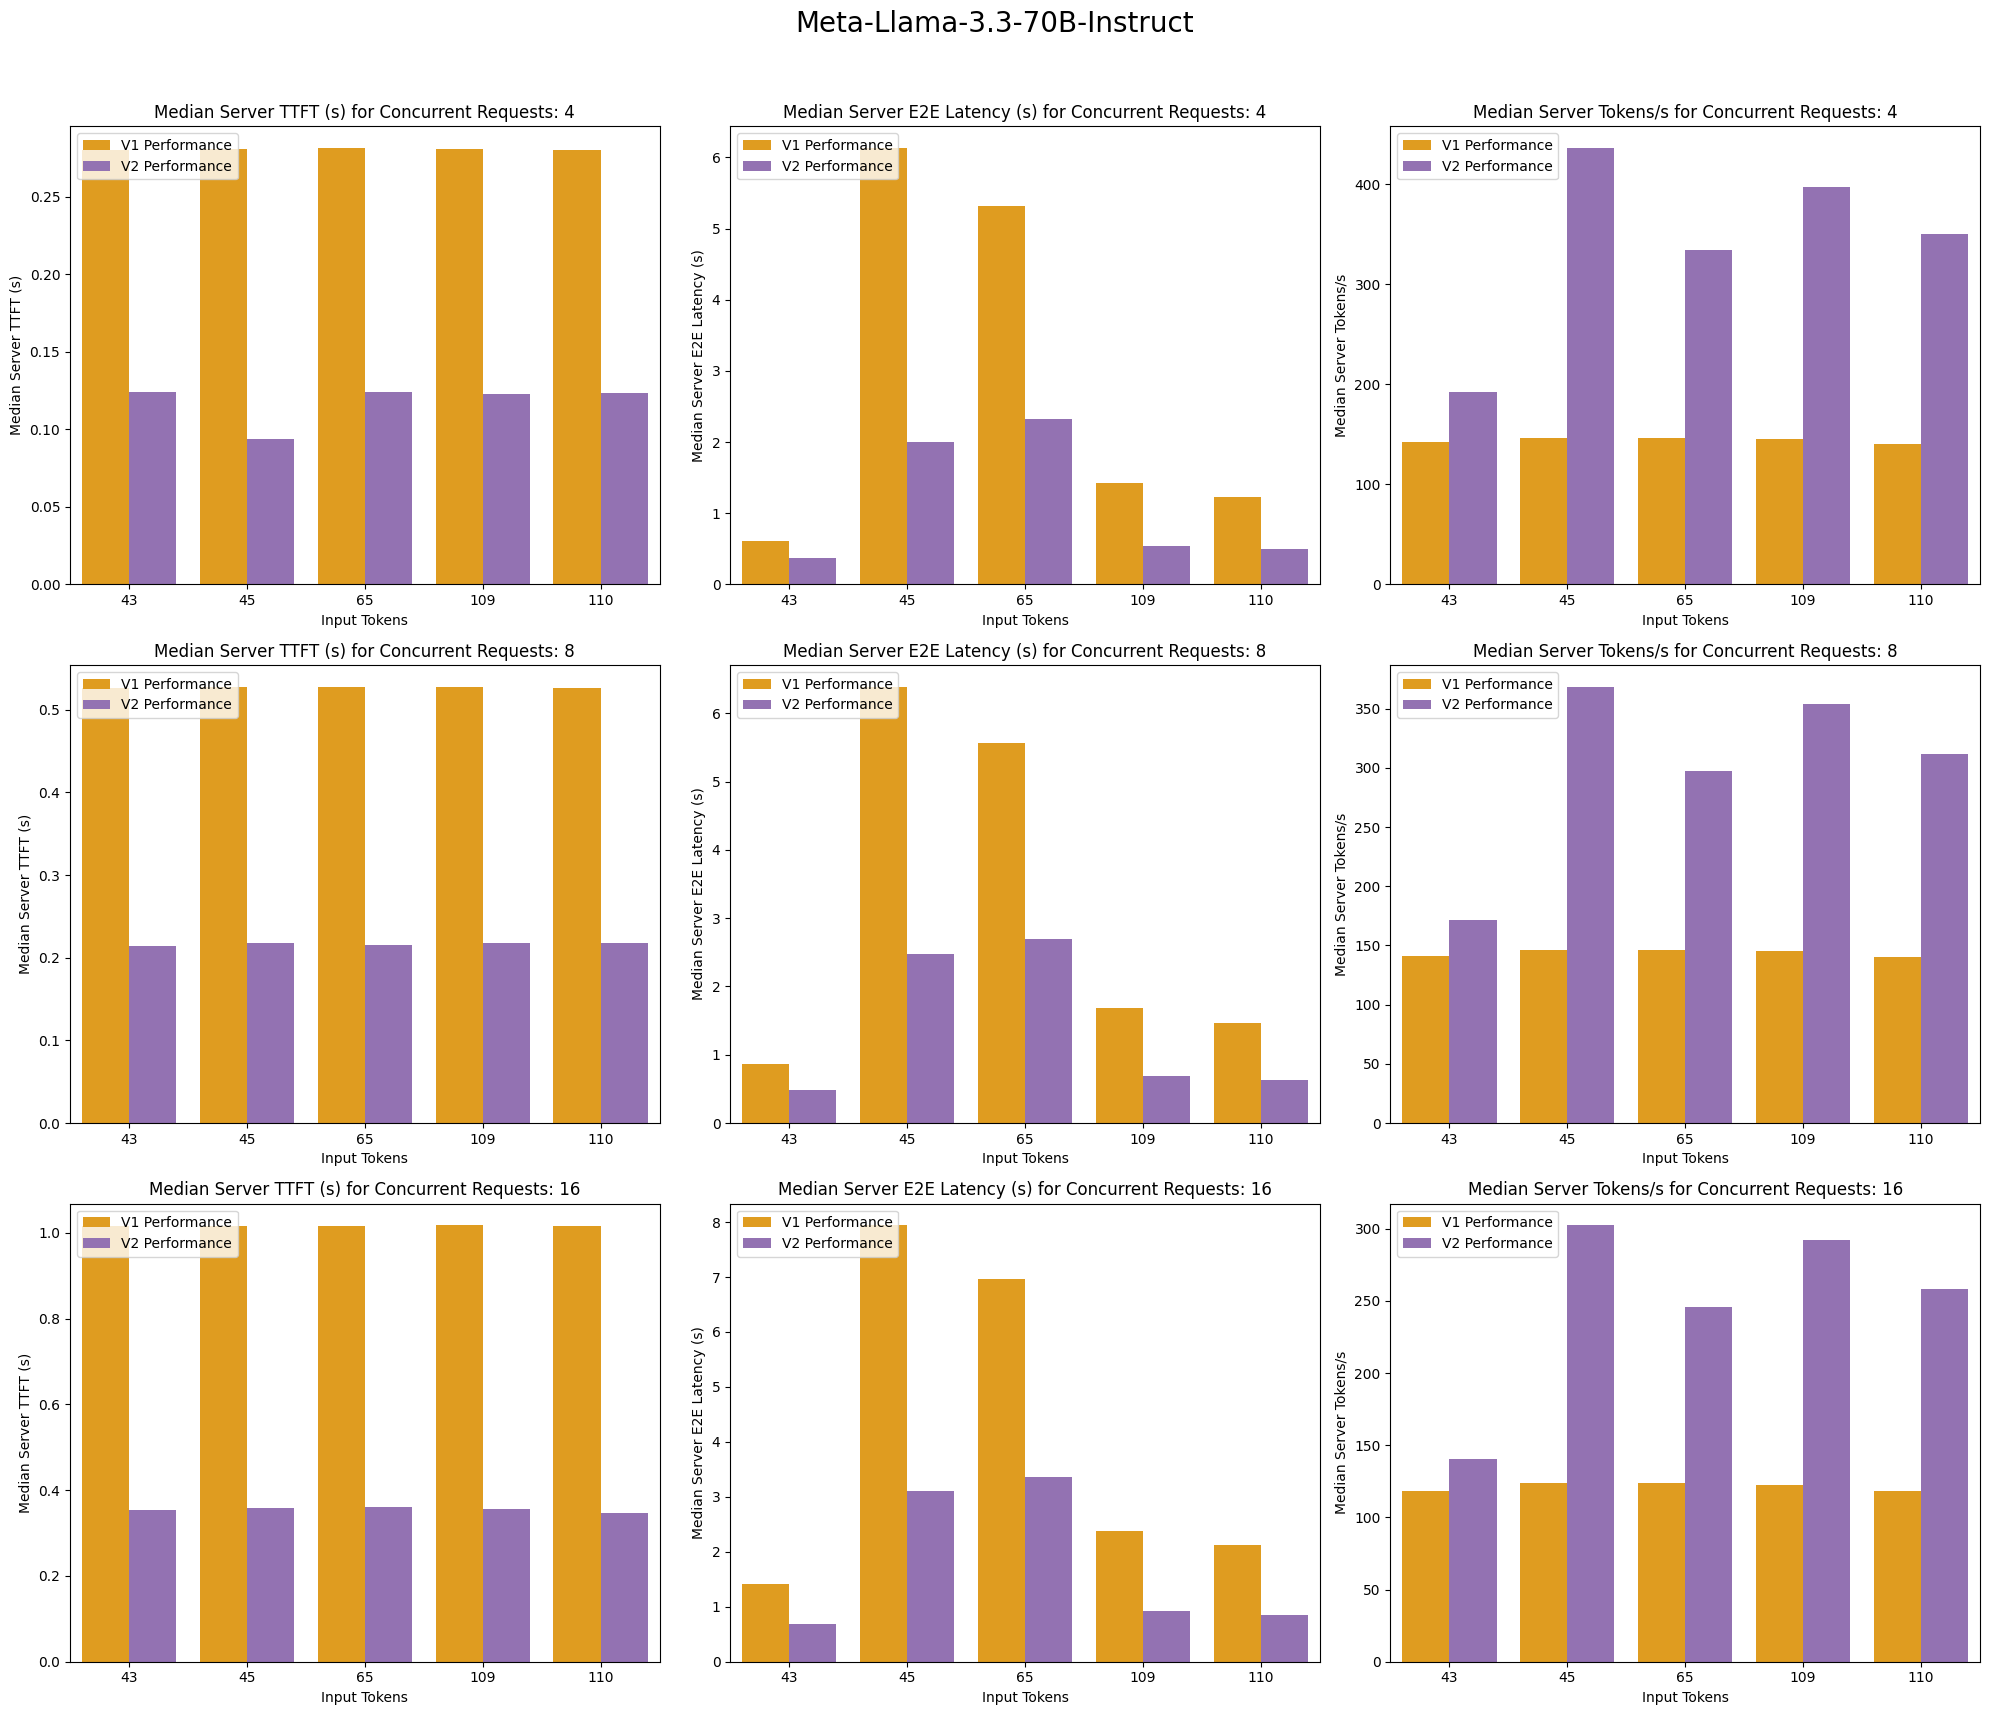

In [32]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Median Server TTFT (s)": "server_ttft_s_p50",
    "Median Server E2E Latency (s)": "server_end_to_end_latency_s_p50",
    "Median Server Tokens/s": "server_output_token_per_s_p50",
}

# Get unique concurrent values
concurrent_values = sorted(config['concurrent_requests'])
selected_models = ['Meta-Llama-3.3-70B-Instruct']

plt.clf()
for target_model in selected_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

<Figure size 640x480 with 0 Axes>

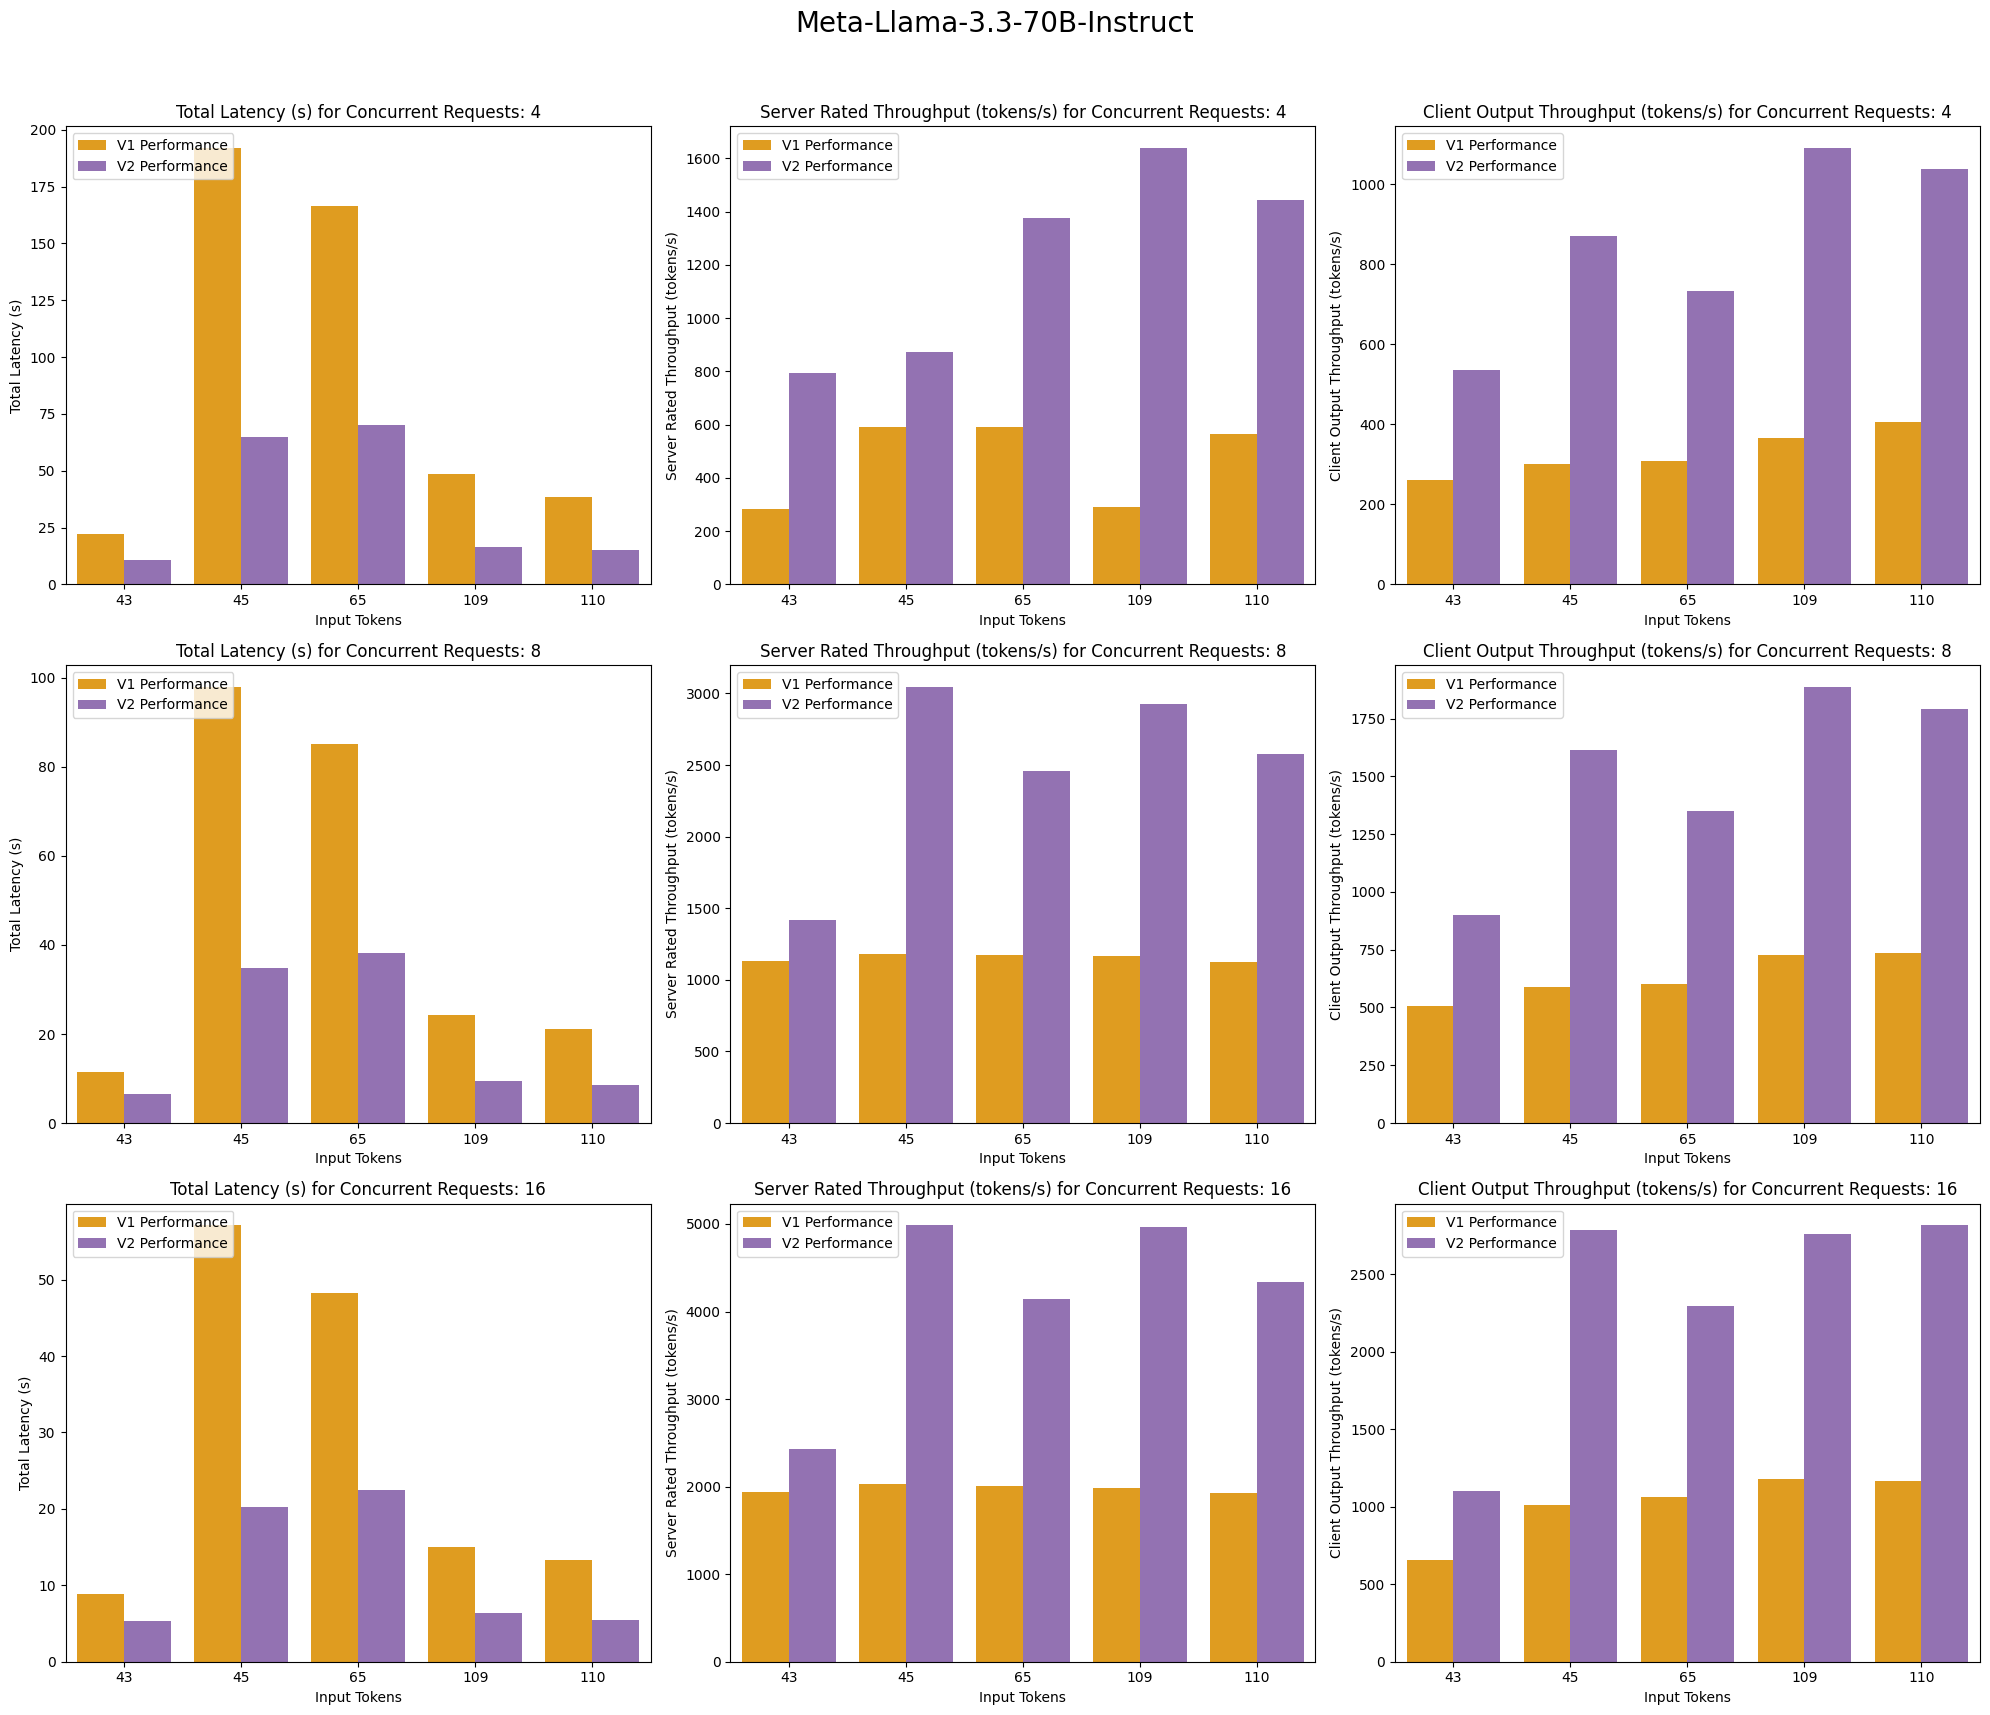

In [33]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Total Latency (s)": "total_latency",
    "Server Rated Throughput (tokens/s)": "server_rated_throughput",
    "Client Output Throughput (tokens/s)": "client_total_throughput",
}

plt.clf()
for target_model in selected_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

